# НУЖНО ПОНЯТЬ НУЖНО ЛИ И МОЖНО ЛИ ВЗВЕШИВАТЬ
# МИГРАЦИЮ В ГОРОД по специалистам в городе
### или не фильтровать а как-то менять их параметры МИГРАЦИИ В ГОРОД

In [1]:
METRIC_CRS = 3857
DEGREE_CRS = 4326

POPULATION_WEIGHT_COEFF = 1
FACTORY_SALARY_W_COEFF = 3
CITY_PARAMS_W_COEFF = 3
BAD_CLIMATE_W_COEFF = 3

MIN_FLOW_VALUE = 1

DISTANCE_TRASHOLD_METERS = (
    1e6  # 250km as a max value for potential migration, exper evaluation
)
"""
да тут правда странные коэффициенты
но мне кажется у меня есть объяснение почему
- птому что модель делает фит к тем данным которые есть и на них генерит
- данные ну такое да
- чтобы это как-то подружить здесь и далее применяются некоторые ходы
по манипуляции с данными, чтобы в итоге всё вместе выглядело норм.

- из минусов -- немного криво генерятся потоки в том плане что в среднем
значения около 115 чел. С другой стороны это вроде ок тк есть пусть и небольшое но существующее различие
между более сильными и более слабыми потоками (в целом как это и должно быть) 

(! ! !)
также тут в (для) для текущего проекта (!) сделано значительное допущение:
стоит ограничение на потоки (но уже после фита / расчета те происходит удаление потоков)
по расстоянию в 250 км -- с идеей показать только ближайшие взаимодействия

Тк именно в этом прокте важно смотреть такие взаимдействия и миграции условно
через пол страны в данном случае нет смысла смотреть тк проект не про это
"""
DESTINATION_EXP_COEFF = 5
ORIGIN_EXP_COEFF = 1
DETERRENCE_FUNC_COEFF = -1


In [2]:
import warnings
import os

import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from skmob.models.gravity import Gravity
import skmob
import numpy as np
import random
import shapely
import folium
from shapely.geometry import LineString
from pandarallel import pandarallel
import pickle

# Initialize pandarallel
pandarallel.initialize(progress_bar=False)

# Suppress FutureWarning messages
warnings.simplefilter(action="ignore", category=FutureWarning)

np.random.seed(0)
random.seed(0)


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [1]:
!conda install -c conda-forge shapely=2.0.5 -y


Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/homebrew/anaconda3/envs/skmob2

  added / updated specs:
    - shapely=2.0.5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cfitsio-3.470              |       ha83d327_7         1.2 MB  conda-forge
    fiona-1.9.1                |  py310h2e51ddd_0         749 KB  conda-forge
    gdal-3.6.2                 |  py310h8924233_3         1.4 MB
    geopandas-0.13.2           |     pyhd8ed1ab_1           7 KB  conda-forge
    geopandas-base-0.13.2      |     pyha770c72_1         988 KB  conda-forge
    geos-3.9.1                 |       h9f76cd9_2         872 KB  conda-forge
    geotiff-1.7.0              |       h41f0982_1         126 KB
    hdf4-4.2.13                |    h0ef36ac_1005         875 KB  conda-forge
    hdf5-1.12.1                |nompi_hd9dbc9e

In [4]:
# !conda install -c conda-forge numpy pandas geopandas shapely -y
# !conda install -c conda-forge pyarrow -y


In [5]:
cols = [
    "population",
    "factories_total",
    "median_salary",
    "ueqi_residential",
    "ueqi_street_networks",
    "ueqi_green_spaces",
    "ueqi_public_and_business_infrastructure",
    "ueqi_social_and_leisure_infrastructure",
    "ueqi_citywide_space",
    "harsh_climate",
]

cols_to_round = ["city_attractiveness_coeff", "population"]


In [6]:
cities_file_path = (
    "/Users/test/Documents/code/IL2/factory_loc_service/api/app/data/cities.parquet"
)

od_file_path = (
    "/Users/test/Documents/code/IL2/industrial-location/api/app/data/OD.parquet"
)


In [7]:
OD = pd.read_parquet(od_file_path).T

cities = gpd.read_parquet(
    cities_file_path,
    # columns=cols + ["region_city", "migrations_from_each_city", "geometry"],
).to_crs(METRIC_CRS)


In [8]:
gg = pd.read_pickle(
    "/Users/test/Documents/code/IL2/factory_loc_service/api/app/data/grouped_grads.pkl"
)
gg["id_cv"].fillna(10, inplace=True)
gg['city_capacity_grads_and_cv_sum'] = gg['id_cv']+gg['graduates_per_year_forecast'].fillna(0)
gg.to_pickle("/Users/test/Documents/code/IL2/factory_loc_service/api/app/data/grouped_grads.pkl")


In [9]:
gg[gg['id_cv']<10].sort_values(by='id_cv')


graduates_per_year_forecast  \
cluster_center               region_city                  type edu_group_code                                
Курская область, Курчатов    Курская область, Дьяконово   CV   15                                      NaN   
Иркутская область, Байкальск Иркутская область, Байкальск CV   4                                       NaN   
Псковская область, Пыталово  Псковская область, Пыталово  CV   19                                      NaN   
Иркутская область, Байкальск Бурятия, Оер                 CV   24                                      NaN   
                                                               15                                      NaN   
...                                                                                                    ...   
Брянская область, Новозыбков Брянская область, Новозыбков CV   24                                      NaN   
Забайкальский край, Хилок    Бурятия, Хоринск             CV   8                                       NaN   
Алтайский край, Барнаул      Алтайский край, Озерки       CV   15                                      NaN   
Нижегородская область, Бор   Нижегородская область, Бор   CV   26                                      NaN   
Магаданская область, Магадан Магаданская область, Магадан CV   24                                      NaN   

                                                                               id_cv  \
cluster_center               region_city                  type edu_group_code          
Курская область, Курчатов    Курская область, Дьяконово   CV   15                1.0   
Иркутская область, Байкальск Иркутская область, Байкальск CV   4                 1.0   
Псковская область, Пыталово  Псковская область, Пыталово  CV   19                1.0   
Иркутская область, Байкальск Бурятия, Оер                 CV   24                1.0   
                                                               15                1.0   
...                                                                              ...   
Брянская область, Новозыбков Брянская область, Новозыбков CV   24                9.0   
Забайкальский край, Хилок    Бурятия, Хоринск             CV   8                 9.0   
Алтайский край, Барнаул      Алтайский край, Озерки       CV   15                9.0   
Нижегородская область, Бор   Нижегородская область, Бор   CV   26                9.0   
Магаданская область, Магадан Магаданская область, Магадан CV   24                9.0   

                                                                               city_capacity_grads_and_cv_sum  
cluster_center               region_city                  type edu_group_code                                  
Курская область, Курчатов    Курская область, Дьяконово   CV   15                                         1.0  
Иркутская область, Байкальск Иркутская область, Байкальск CV   4                                          1.0  
Псковская область, Пыталово  Псковская область, Пыталово  CV   19                                         1.0  
Иркутская область, Байкальск Бурятия, Оер                 CV   24                                         1.0  
                                                               15                                         1.0  
...                                                                                                       ...  
Брянская область, Новозыбков Брянская область, Новозыбков CV   24                                         9.0  
Забайкальский край, Хилок    Бурятия, Хоринск             CV   8                                          9.0  
Алтайский край, Барнаул      Алтайский край, Озерки       CV   15                                         9.0  
Нижегородская область, Бор   Нижегородская область, Бор   CV   26                                         9.0  
Магаданская область, Магадан Магаданская область, Магадан CV   24                                         9.0  

[54994 rows x 3 columns]

In [10]:
# cities["median_salary"] += 50e3


In [11]:
def define_model():
    gravity = Gravity(
        deterrence_func_type="power_law",
        gravity_type="globally constrained",
        destination_exp=DESTINATION_EXP_COEFF,
        origin_exp=ORIGIN_EXP_COEFF,
        deterrence_func_args=[DETERRENCE_FUNC_COEFF],
    )

    return gravity


def drop_cities_no_population(df):
    assert "population" in df.columns, "population is not in df.columns"

    mask_not_empty_population_col = df["population"] > 0
    return df.loc[mask_not_empty_population_col, :]


def normalize_outflow_by_pop_mil(df):

    POPULATION_NORMALIZATION_VALUE = 1e6

    assert (
        "migrations_from_each_city" in df.columns and "population" in df.columns
    ), "migrations_from_each_city or population are not in df.columns"

    return cities["migrations_from_each_city"] * (
        cities["population"] / POPULATION_NORMALIZATION_VALUE
    )


def define_scaler():
    return MinMaxScaler()


def scale_cities_attrs(df, cols_to_scale, scaler, fit=True):
    """
    скейлить думаю тоже можно один раз
    потом сохранить скейлер и только для измененных параметров использовать
    """

    if fit:
        return scaler.fit_transform(
            df.loc[
                :,
                cols_to_scale,
            ]
        )

    else:
        df = df.T
        return scaler.transform(
            df.loc[
                :,
                cols_to_scale,
            ]
        )


def calculate_attractiveness(df):
    """
    это как будто тоже один раз и потом просто пересчитывать для одного города

    Почему вес/привлекательность так сделано? Взвешиваются отдельно фабрики-зарплаты, качества города и климат.
    + Я попробовал по-разному их взвешивать (и задавать различные значения для гравити-модели)
    и такая комюинация показала себя лучше всего. Можно считать это экспертной оценкой.
    """

    assert all(
        param in df.columns
        for param in [
            "factories_total",
            "median_salary",
            "ueqi_residential",
            "ueqi_green_spaces",
            "ueqi_public_and_business_infrastructure",
            "ueqi_social_and_leisure_infrastructure",
            "ueqi_citywide_space",
            "harsh_climate",
        ]
    )

    city_attractiveness_coeff = round(
        # POPULATION_WEIGHT_COEFF * df["population"]
        FACTORY_SALARY_W_COEFF
        * (df["factories_total"] + df["median_salary"])
        * CITY_PARAMS_W_COEFF
        + (
            +df["ueqi_residential"]
            + df["ueqi_street_networks"]
            + df["ueqi_green_spaces"]
            + df["ueqi_public_and_business_infrastructure"]
            + df["ueqi_social_and_leisure_infrastructure"]
            + df["ueqi_citywide_space"]
        )
        + (1 - df["harsh_climate"])
        # * BAD_CLIMATE_W_COEFF
        + 1,
        0,
    )

    return city_attractiveness_coeff


def filter_od_matrix_resetted(df):
    """
    вот это кстати можно и один раз сделать
    """

    assert all(param in df.columns for param in ["origin", "destination"])

    mask_od_origin_not_destination = df["origin"] != df["destination"]

    # mask_flow_not_supersmall = od_matrix_reset["flow"] > MIN_FLOW_VALUE
    return df.loc[mask_od_origin_not_destination, :]


def reset_od_matrix(od_matrix):
    """
    тоже можно делать один раз
    """
    # Reset index to have 'origin' as a column
    od_matrix_reset = od_matrix.reset_index()
    od_matrix_reset.rename(columns={"region_city": "origin"}, inplace=True)

    od_matrix_reset = pd.melt(
        od_matrix_reset, id_vars=["origin"], var_name="destination", value_name="flow"
    )

    return od_matrix_reset


def check_filter_cities_in_od_matrix(df, od_df):
    """
    тоже будто можно один раз сделать
    """
    assert "region_city" in df and all(
        param in od_df for param in ["origin", "destination"]
    )

    mask_cities_in_od = df["region_city"].isin(
        set(od_df["origin"].to_list() + od_df["destination"].to_list())
    )

    return df.loc[mask_cities_in_od, :]


def make_flow_df(od_df, df_with_od_geoms):
    """
    тоже можно делать один раз
    """
    fdf = skmob.FlowDataFrame(
        data=od_df,
        origin="origin",
        destination="destination",
        flow="flow",
        tessellation=df_with_od_geoms,
        tile_id="region_city",
    )

    return fdf


def fit_flow_df(fdf, gravity) -> None:
    gravity.fit(fdf, relevance_column="city_attractiveness_coeff")


def generate_flows(df, gravity):
    """
    генерирует таблицу с OD и потоком между

    !!! нужно пересчитыват какждый раз при изменении параметров города

    """
    assert all(
        param in df.columns
        for param in ["city_attractiveness_coeff", "region_city", "norm_outflow"]
    )

    fdf_fitted = gravity.generate(
        df,
        relevance_column="city_attractiveness_coeff",
        tot_outflows_column="norm_outflow",
        out_format="flows",
        tile_id_column="region_city",
    )

    return pd.DataFrame(fdf_fitted).sort_values(by=["flow", "destination"])


def inverse_scale_df(df, cols, scaler):
    return pd.DataFrame(scaler.inverse_transform(df.loc[:, cols]), columns=cols)


def tailor_geometries(gdf):
    GRID_SIZE = 0.001
    return shapely.set_precision(gdf["geometry"].array, grid_size=GRID_SIZE)


def post_processing(gdf: pd.DataFrame):

    assert all(attr in gdf.columns for attr in ["geometry", "flow"])

    MINIMAL_FLOW = 1e-3  # anything beyond is a noise
    MAXIMAL_FLOW = 4  # anything beyond is a noise

    # res["attr_diff"] = res["destination_attr"] - res["origin_attr"]
    gdf["distance"] = (
        gpd.GeoSeries(gdf["geometry"], crs=DEGREE_CRS).to_crs(METRIC_CRS).length
    )
    mask6 = (
        (gdf["distance"] < DISTANCE_TRASHOLD_METERS)
        & (gdf["flow"] > MINIMAL_FLOW)
        & (gdf["flow"] < MAXIMAL_FLOW)
    )
    gdf.loc[:, "big_flows"] = (np.log(gdf.loc[:, "flow"] + 5) ** 10).astype(
        int
    )  # some empirical constants
    gdf.loc[:, "scaled_flows_forvis"] = round(
        np.log(gdf.loc[:, "big_flows"]) / 1e2, 3
    )  # some empirical constants

    return gdf, mask6


def join_od_params(fdf_with_flows, cities):

    df_links = fdf_with_flows.merge(
        cities[["region_city", "city_attractiveness_coeff", "population"]].rename(
            columns={
                "region_city": "destination",
                "city_attractiveness_coeff": "destination_attr",
            }
        ),
        left_on="destination",
        right_on="destination",
    ).merge(
        cities[["region_city", "city_attractiveness_coeff"]].rename(
            columns={
                "city_attractiveness_coeff": "origin_attr",
                "region_city": "origin",
            }
        ),
        left_on="origin",
        right_on="origin",
    )

    return df_links


# Define the function that uses the pre-constructed dictionary
def create_linestring(row, geometry_dict):
    origin = row["origin"]
    destination = row["destination"]

    # Check if both origin and destination exist in the dictionary
    if origin in geometry_dict and destination in geometry_dict:
        return LineString([geometry_dict[origin], geometry_dict[destination]])
    return None


def make_od_linestring_geom(fdf_fitted_df, init_cities):
    """
    Геометрии ставятся один раз --- БРАТЬ ИЗ ФАЙЛА
    """

    # Create a dictionary that maps region cities to their geometries for faster access
    city_geometry_dict = init_cities.set_index("region_city")["geometry"].to_dict()
    # Apply the function in parallel
    return fdf_fitted_df.parallel_apply(
        lambda row: create_linestring(row, city_geometry_dict), axis=1
    )


def make_folium_map(gdf_links, cities, region_poly=None):
    assert all(
        attr in gdf_links.columns
        for attr in [
            "geometry",
            "scaled_flows_forvis",
            "origin",
            "destination",
            "big_flows",
        ]
    )

    assert isinstance(gdf_links, gpd.GeoDataFrame)
    assert isinstance(cities, gpd.GeoDataFrame)

    m = gdf_links[
        ["geometry", "scaled_flows_forvis", "origin", "destination", "big_flows"]
    ].explore(
        scheme="Percentiles",
        column="big_flows",
        cmap="Accent_r",
        style_kwds={
            "style_function": lambda feature: {
                "weight": (
                    feature["properties"]["scaled_flows_forvis"] + 1
                ),  # Set line width based on the attribute
                "opacity": 0.3,  # Adjust opacity if necessary
            }
        },
        control_scale=True,
        vmin=10,
        vmax=2.5e2,
        tiles="Cartodb dark_matter",
    )

    # Create a style function for circle markers
    def style_function(x, min_radius=1, max_radius=10):

        # Get the value for the chosen parameter
        flows_in_value = x["flows_in"]  # Default to 1 to avoid log(0) errors
        flows_out_value = x["flows_out"]  # Default to 1 to avoid log(0) errors

        # Compute the logarithmic value (base 10 or natural log)
        log_flows_in_value = np.sqrt(
            flows_in_value
        )  # Natural logarithm, you can use np.log10() for base 10

        # Compute the logarithmic value (base 10 or natural log)
        log_flows_out_value = np.sqrt(
            flows_out_value
        )  # Natural logarithm, you can use np.log10() for base 10

        # Normalize the log value to adjust the circle radius
        # Ensure the log value is scaled between min_radius and max_radius
        # marker_radius = min(max(flows_in_value, min_radius), max_radius)
        # border_radius = min(max(flows_out_value, min_radius), max_radius)

        return folium.CircleMarker(
            location=[x["geometry"].y, x["geometry"].x],
            radius=flows_in_value / 500,  # Adjust radius as needed
            # weight=log_flows_out_value / 5,
            popup=x[["region_city", "flows_in", "flows_out"]],
            fill=True,
            # fill_color="white",
            weight=1,
            color="white",
            opacity=1,  # Set border opacity
            fill_color="black",
            fill_opacity=0.01,
        ).add_to(m)

    # Apply the function to each feature in GeoJson
    cities.apply(lambda row: style_function(row), axis=1)

    # Create an HTML title element
    title_text = "Все потоки без разделения по профессиям"
    title_html = f"""
        <div style="
            position: fixed; 
            top: 10%;  
            left: 20%; 
            transform: translateX(-50%);
            background-color: transparent; 
            color: white; 
            font-size: 20px; 
            font-weight: bold;
            z-index: 1000;">
            {title_text}
        </div>
        """

    if isinstance(region_poly, gpd.GeoDataFrame):

        # Add the GeoDataFrame as a GeoJSON layer with borders only
        folium.GeoJson(
            region_poly.geometry.item().boundary,
            name="geojson",
            style_function=lambda feature: {
                "fillOpacity": 0,  # No fill
                # "fill_color": "yellow",
                "color": "white",  # Border color
                "weight": 0.4,  # Border thickness
            },
        ).add_to(m)

    # Add the title element to the map
    m.get_root().html.add_child(folium.Element(title_html))
    # Add layer control to toggle GeoJSON layer visibility
    folium.LayerControl().add_to(m)

    return m


In [12]:
class WorkForceFlows:
    def __init__(self):
        self.cols = [
            "population",
            "factories_total",
            "median_salary",
            "ueqi_residential",
            "ueqi_street_networks",
            "ueqi_green_spaces",
            "ueqi_public_and_business_infrastructure",
            "ueqi_social_and_leisure_infrastructure",
            "ueqi_citywide_space",
            "harsh_climate",
        ]
        self.cols_to_round = ["city_attractiveness_coeff", "population"]

        # Flag for tracking which stages need recalculation
        self.pipeline_stages = {
            1: False,
            2: False,
            3: False,
            4: False,
            5: False,
            6: False,
            7: False,
            8: False,
        }

        # Track initial state of cities
        self.initial_cities_state = None
        self.initial_links_state = None
        self.prev_cities_state = None  # Track the last saved state (for comparison)
        self.prev_links_state = None
        self.current_cities_state = None  # Track the current state of cities
        self.current_links_state = None
        self.scaled_cities = None
        self.update_city_name = None
        self.update_city_name_idx = None
        self.updated_city_params = None
        self.fdf = None
        self.od_linestrings = None

    def __getitem__(self, key):
        return getattr(self, key, f"Property '{key}' not found")

    def __setitem__(self, key, value):
        if hasattr(self, key):
            print("Warning: rewriting existing attribute")
        setattr(self, key, value)

    def save_initial_state(self):
        """Save the initial state of cities dataframe."""
        if self.initial_cities_state is None:
            self.initial_cities_state = self.cities.copy()
            self.initial_links_state = self.gdf_links.copy()
            print("Initial cities state saved.")

    def save_previous_state(self):
        """Save the previous state of cities dataframe."""
        self.prev_cities_state = self.cities.copy()
        self.prev_links_state = self.gdf_links.copy()

    def save_current_state(self):
        """Save the previous state of cities dataframe."""
        self.current_cities_state = self.cities.copy()
        self.current_links_state = self.gdf_links.copy()

    def compare_city_states(self):
        """Compare two states of the cities DataFrame or any other DataFrame."""
        # You can compare the full dataframe or specific columns
        if hasattr(self, "current_cities_state") and hasattr(
            self, "initial_cities_state"
        ):
            diff_cities = self.current_cities_state[
                ["flows_in", "flows_out", "region_city", "geometry"]
            ].merge(
                self.initial_cities_state[
                    ["flows_in", "flows_out", "region_city"]
                ].rename(
                    columns={"flows_in": "flows_in_prev", "flows_out": "flows_out_prev"}
                )
            )

            diff_cities["in_diff"] = (
                diff_cities["flows_in"] - diff_cities["flows_in_prev"]
            )

            diff_cities["out_diff"] = (
                diff_cities["flows_out"] - diff_cities["flows_out_prev"]
            )

            diff_cities["in_out_diff"] = (
                diff_cities["in_diff"] - diff_cities["out_diff"]
            )

            # Set a threshold for filtering small fluctuations
            threshold = 3  # Adjust this value based on your data
            # Filter out points with 'in_out_diff' below the threshold
            mask_fluctuation = diff_cities["in_out_diff"].abs() <= threshold
            diff_cities.loc[mask_fluctuation, "in_out_diff"] = 0

            return diff_cities[
                ["region_city", "geometry", "in_out_diff", "in_diff", "out_diff"]
            ].to_crs(DEGREE_CRS)
        else:
            print("Both states must be DataFrame objects.")
            return False

    def compare_link_states(self):
        """Compare two states of the cities DataFrame or any other DataFrame."""
        # You can compare the full dataframe or specific columns
        if hasattr(self, "current_cities_state") and hasattr(
            self, "initial_links_state"
        ):
            diff_links = (
                self.initial_links_state[
                    [
                        "origin",
                        "destination",
                        "big_flows",
                        "geometry",
                        "scaled_flows_forvis",
                    ]
                ]
                .rename(columns={"big_flows": "init_flows"})
                .merge(
                    self.current_links_state[["origin", "destination", "big_flows"]],
                )
            )

            diff_links["big_flows"] = diff_links["big_flows"] - diff_links["init_flows"]

            # Set a threshold for filtering small fluctuations
            threshold = 3  # Adjust this value based on your data
            # Filter out points with 'in_out_diff' below the threshold
            mask_fluctuation = diff_links["big_flows"].abs() <= threshold
            diff_links.loc[mask_fluctuation, "big_flows"] = 0

            return diff_links.drop(columns=["init_flows"])
        else:
            print("Both states must be DataFrame objects.")
            return False

    def reset_state(self):
        """Reset to the initial state of cities."""
        if self.initial_cities_state is not None:
            self.cities = self.initial_cities_state.copy()
            print("Cities state reset to the initial state.")
        else:
            print("No initial state to reset to.")

    @classmethod
    def make_scaler(cls):
        cls.scaler = define_scaler()

    @classmethod
    def make_model(cls):
        cls.model = define_model()

    def mark_stage_dirty(self, stage_number):
        # Mark a stage and all subsequent stages as needing rerun
        for stage in range(stage_number, max(self.pipeline_stages.keys()) + 1):
            self.pipeline_stages[stage] = False

    def run_cities_pipeline_stage_1(self):
        if not self.pipeline_stages[1]:
            if hasattr(self, "cities"):
                self.cities = drop_cities_no_population(self.cities)
                self.cities["norm_outflow"] = normalize_outflow_by_pop_mil(self.cities)
                self.pipeline_stages[1] = True
                self.mark_stage_dirty(2)  # Mark later stages as needing rerun
            else:
                warnings.warn("Please provide 'cities' data")
        else:
            print("Skipping: Stage 1 has already been run")

    def run_cities_pipeline_stage_2(self):
        if not self.pipeline_stages[2]:
            if hasattr(self, "cities"):
                self.init_cities = self.cities.copy().to_crs(DEGREE_CRS)
                self.init_cities["geometry"] = tailor_geometries(self.init_cities)
                self.pipeline_stages[2] = True
                self.mark_stage_dirty(3)  # Stage 3 depends on Stage 2
            else:
                warnings.warn("Please provide 'cities' data")
        else:
            print("Skipping: Stage 2 has already been run")

    def run_cities_pipeline_stage_3(self):
        if not self.pipeline_stages[3]:
            if hasattr(self, "cities") and hasattr(self, "od"):
                self.od_matrix_reset = reset_od_matrix(self["od"])
                self.od_matrix_reset = filter_od_matrix_resetted(self.od_matrix_reset)
                self.od_matrix_reset.reset_index(drop=True, inplace=True)
                # self.cities = check_filter_cities_in_od_matrix(
                #     self.cities, self.od_matrix_reset
                # )
                self.pipeline_stages[3] = True
                self.mark_stage_dirty(4)  # Stage 4 depends on Stage 3
            else:
                warnings.warn("Please provide 'cities' and 'od' data")
        else:
            print("Skipping: Stage 3 has already been run")

    def run_cities_pipeline_stage_4(self):
        if not self.pipeline_stages[4]:
            if hasattr(self, "cities") and hasattr(self, "scaler"):

                self.cities.loc[:, self.cols] = scale_cities_attrs(
                    self.cities, self.cols, self.scaler, fit=True
                )
                self.scaled_cities = self.cities.copy()
                self.cities["city_attractiveness_coeff"] = calculate_attractiveness(
                    self.cities
                )
                self.init_cities["city_attractiveness_coeff"] = self.cities[
                    "city_attractiveness_coeff"
                ].copy()

                self.pipeline_stages[4] = True
                self.mark_stage_dirty(5)  # Stage 5 depends on Stage 4
            else:
                warnings.warn("Please provide 'cities' data and a scaler")
        else:
            print("Skipping: Stage 4 has already been run")

    def run_cities_pipeline_stage_5(self):
        if not self.pipeline_stages[5]:
            if hasattr(self, "cities") and hasattr(self, "od_matrix_reset"):

                self.fdf = make_flow_df(self.od_matrix_reset, self.cities)
                self.cities.loc[:, self.cols] = inverse_scale_df(
                    self.cities, self.cols, self.scaler
                )
                self.cities.loc[:, self.cols_to_round] = self.cities.loc[
                    :, self.cols_to_round
                ].astype(int)
                self.pipeline_stages[5] = True
                self.mark_stage_dirty(6)  # Stage 6 depends on Stage 5
            else:
                warnings.warn("Please provide 'cities' and 'od_matrix_reset' data")
        else:
            print("Skipping: Stage 5 has already been run")

    def run_cities_pipeline_stage_6(self):
        if not self.pipeline_stages[6]:
            if hasattr(self, "fdf") and hasattr(self, "init_cities"):
                fit_flow_df(self.fdf, self.model)  # Fit the model with flow data
                self.fdf_fitted_df = generate_flows(self.cities, self.model)
                self.pipeline_stages[6] = True
                self.mark_stage_dirty(7)  # Stage 7 depends on Stage 6
            else:
                warnings.warn("Please provide 'fdf' and 'init_cities' data")
        else:
            print("Skipping: Stage 6 has already been run")

    def run_cities_pipeline_stage_7(self):
        if not self.pipeline_stages[7]:
            if hasattr(self, "fdf_fitted_df") and hasattr(self, "init_cities"):
                self.od_linestrings = make_od_linestring_geom(
                    self.fdf_fitted_df, self.init_cities
                )
                self.fdf_fitted_df["geometry"] = self.od_linestrings
                self.pipeline_stages[7] = True
                self.mark_stage_dirty(8)  # Stage 8 depends on Stage 7
            else:
                warnings.warn("Please provide 'fdf_fitted_df' and 'init_cities' data")
        else:
            print("Skipping: Stage 7 has already been run")

    def run_cities_pipeline_stage_8(self):
        if not self.pipeline_stages[8]:
            if hasattr(self, "fdf_fitted_df") and hasattr(self, "init_cities"):
                self.df_links = join_od_params(self.fdf_fitted_df, self.cities)
                self.df_links, self.mask_distance_flow = post_processing(self.df_links)
                self.gdf_links = gpd.GeoDataFrame(
                    self.df_links[self.mask_distance_flow], crs=DEGREE_CRS
                )
                self.gdf_links["geometry"] = tailor_geometries(self.gdf_links)
                self.pipeline_stages[8] = True

                flows_grouped_out = (
                    (
                        self.gdf_links.drop(columns=["destination", "geometry"])
                        .groupby("origin")
                        .sum()
                        .reset_index(drop=False)
                    )
                    .loc[:, ["origin", "big_flows"]]
                    .rename(columns={"big_flows": "flows_out", "origin": "region_city"})
                )

                flows_grouped_in = (
                    (
                        self.gdf_links.drop(columns=["origin", "geometry"])
                        .groupby("destination")
                        .sum()
                        .reset_index(drop=False)
                    )
                    .loc[:, ["destination", "big_flows"]]
                    .rename(
                        columns={"big_flows": "flows_in", "destination": "region_city"}
                    )
                )

                self.cities = self.cities.merge(flows_grouped_in, how="left").merge(
                    flows_grouped_out, how="left"
                )

                self.save_initial_state()
                self.save_current_state()

            else:
                warnings.warn("Please provide 'fdf_fitted_df' and 'cities' data")
        else:
            print("Skipping: Stage 8 has already been run")

    # -----------------------------------------------------------------
    def run_cities_pipeline_stage_4_upd(self):
        if not self.pipeline_stages[4]:
            if hasattr(self, "cities") and hasattr(self, "scaler"):
                if self.update_city_name:

                    self.scaled_cities.loc[self.update_city_name_idx, self.cols] = (
                        scale_cities_attrs(
                            self.cities.loc[self.update_city_name_idx, :].to_frame(),
                            self.cols,
                            self.scaler,
                            fit=False,
                        )
                    )

                    self.cities.loc[
                        self.update_city_name_idx, "city_attractiveness_coeff"
                    ] = calculate_attractiveness(
                        self.scaled_cities.loc[self.update_city_name_idx, :]
                        .to_frame()
                        .T
                    ).item()

                    self.pipeline_stages[4] = True
                    self.mark_stage_dirty(5)  # Stage 5 depends on Stage 4
            else:
                warnings.warn("Please provide 'cities' data and a scaler")
        else:
            print("Skipping: Stage 4 has already been run")

    def run_cities_pipeline_stage_5_upd(self):
        if not self.pipeline_stages[5]:
            if hasattr(self, "cities") and hasattr(self, "od_matrix_reset"):

                self.cities.loc[self.update_city_name_idx, self.cols_to_round] = (
                    self.cities.loc[
                        self.update_city_name_idx, self.cols_to_round
                    ].astype(int)
                )

                self.pipeline_stages[5] = True
                self.mark_stage_dirty(6)  # Stage 6 depends on Stage 5
            else:
                warnings.warn("Please provide 'cities' and 'od_matrix_reset' data")
        else:
            print("Skipping: Stage 5 has already been run")

    def run_cities_pipeline_stage_6_upd(self):
        if not self.pipeline_stages[6]:
            if hasattr(self, "fdf") and hasattr(self, "init_cities"):

                # fit_flow_df(self.fdf, self.model)  # Fit the model with flow data
                self.fdf_fitted_df = generate_flows(self.cities, self.model)

                self.pipeline_stages[6] = True
                self.mark_stage_dirty(7)  # Stage 7 depends on Stage 6
            else:
                warnings.warn("Please provide 'fdf' and 'init_cities' data")
        else:
            print("Skipping: Stage 6 has already been run")

    def run_cities_pipeline_stage_7_upd(self):
        if not self.pipeline_stages[7]:
            fitted_df = getattr(self, "fdf_fitted_df", None)
            if fitted_df is not None:
                # Use direct assignment to avoid unnecessary copies
                fitted_df["geometry"] = self.od_linestrings
                self.pipeline_stages[7] = True
                self.mark_stage_dirty(8)  # Marking stage 8 as dependent

            else:
                warnings.warn("Please provide 'fdf_fitted_df' and 'init_cities' data")
        else:
            print("Skipping: Stage 7 has already been run")

    def run_cities_pipeline_stage_8_upd(self):
        if not self.pipeline_stages[8]:
            fitted_df = getattr(self, "fdf_fitted_df", None)
            cities_df = getattr(self, "cities", None)

            if fitted_df is not None and cities_df is not None:
                self.df_links = join_od_params(fitted_df, cities_df)
                # Perform post-processing and get masks in a single step if possible
                self.df_links, self.mask_distance_flow = post_processing(self.df_links)

                # Create GeoDataFrame directly without reassignment
                self.gdf_links = gpd.GeoDataFrame(
                    self.df_links.loc[self.mask_distance_flow], crs=DEGREE_CRS
                )
                self.gdf_links["geometry"] = tailor_geometries(self.gdf_links)

                self.pipeline_stages[8] = True

                # Optimize groupby operations by using fewer temporary DataFrames
                flows_out = (
                    self.gdf_links.drop(columns=["destination", "geometry"])
                    .groupby("origin", as_index=False)["big_flows"]
                    .sum()
                    .rename(columns={"big_flows": "flows_out", "origin": "region_city"})
                )

                # Drop columns in place to minimize data copying
                if "flows_in" in cities_df.columns:
                    cities_df.drop(columns=["flows_in", "flows_out"], inplace=True)

                flows_in = (
                    self.gdf_links.drop(columns=["origin", "geometry"])
                    .groupby("destination", as_index=False)["big_flows"]
                    .sum()
                    .rename(
                        columns={"big_flows": "flows_in", "destination": "region_city"}
                    )
                )

                # Merge flows more efficiently
                self.cities = cities_df.merge(flows_in, how="left").merge(
                    flows_out, how="left"
                )

                self.save_current_state()

            else:
                warnings.warn("Please provide 'fdf_fitted_df' and 'cities' data")
        else:
            print("Skipping: Stage 8 has already been run")

    # -----------------------------------------------------------------

    def update_city_params(self, city_name, new_params):
        # Check if the city exists in the DataFrame

        self.save_previous_state()

        self.update_city_name = city_name
        self.updated_city_params = new_params

        if city_name in self.cities["region_city"].values:
            # Update the DataFrame for the specific city
            self.update_city_name_idx = self.cities[
                self.cities["region_city"] == city_name
            ].index.item()

            self.cities.loc[self.update_city_name_idx, new_params.keys()] = (
                new_params.values()
            )
            print(f"Updated parameters for {city_name}")
            # Mark relevant stages as dirty
            self.mark_stage_dirty(
                4
            )  # Stage 4 needs rerunning after updating city params
        else:
            print(f"City {city_name} not found in the DataFrame.")

    def recalculate_after_update(self):
        """
        Updates city parameters and recalculates the pipeline from Stage 4 to Stage 8.

        :param city_name: Name of the city whose parameters need to be updated
        :param new_params: Dictionary of the new parameters to update the city with
        """

        # Step 2: Re-run necessary pipeline stages after update
        print(f"Recalculating after updating parameters")

        self.run_cities_pipeline_stage_4_upd()  # Recalculate Stage 4
        self.run_cities_pipeline_stage_5_upd()  # Recalculate Stage 5
        self.run_cities_pipeline_stage_6_upd()  # Recalculate Stage 6
        self.run_cities_pipeline_stage_7_upd()  # Recalculate Stage 7
        self.run_cities_pipeline_stage_8_upd()  # Recalculate Stage 8

        print(f"Recalculation complete.")

    def to_pickle(self, filename):
        """Save the whole class instance to a pickle file."""
        with open(filename, "wb") as f:
            pickle.dump(self, f)
        print(f"Class instance saved to {filename}")

    @classmethod
    def from_pickle(cls, filename):
        """Load the class instance from a pickle file."""
        with open(filename, "rb") as f:
            instance = pickle.load(f)
        print(f"Class instance loaded from {filename}")
        return instance


In [13]:
"""
В начале нужно запустить все, сохранить модель
Некоторые могут быть просто прикручены -- например 7, это надо починить
чтобы условно если оно есть то тупо бы прикручивалось конкатом без вычислений
"""

filename = "wff_model_1711.pkl"

if filename in os.listdir():
    wff = WorkForceFlows.from_pickle(filename)
else:
    wff = WorkForceFlows()
    wff.make_scaler()
    wff.make_model()
    wff["od"] = OD
    wff["cities"] = cities
    wff.run_cities_pipeline_stage_1()
    wff.run_cities_pipeline_stage_2()
    wff.run_cities_pipeline_stage_3()
    wff.run_cities_pipeline_stage_4()  # this one is updatable -- update cities
    wff.run_cities_pipeline_stage_5()  # this one needs to be re-run after stage_5
    wff.run_cities_pipeline_stage_6()  # this one needs to be re-run after update
    wff.run_cities_pipeline_stage_7()  # this one needs to be re-run after stage_6
    wff.run_cities_pipeline_stage_8()  # this one needs to be re-run after update


AttributeError: module 'shapely' has no attribute 'set_precision'

In [ ]:
df = pd.read_pickle("/Users/test/Documents/code/IL2/factory_loc_service/api/app/df.pkl")


In [ ]:
wff.cities.to_crs(4326).to_parquet(
    "/Users/test/Documents/code/IL2/factory_loc_service/api/app/data/cities1812.parquet"
)


In [ ]:
wff.cities


,region_city,city_category,migrations_from_each_city,population,harsh_climate,ueqi_residential,ueqi_street_networks,ueqi_green_spaces,ueqi_public_and_business_infrastructure,ueqi_social_and_leisure_infrastructure,...,factories_total,h3_index,median_salary,num_in_migration,estimate,geometry,norm_outflow,city_attractiveness_coeff,flows_in,flows_out
0,"Хакасия, Абаза",Малый город,3.547322,12055.0,0.0,36.0,34.0,27.0,16.0,20.0,...,0.0,862535cc7ffffff,20000.0,0.390940,0.512,POINT (10029615.948 6917986.994),0.042763,6.0,234.0,234.0
1,"Хакасия, Абакан",Большой город,30.011400,185348.0,0.0,36.0,37.0,24.0,37.0,36.0,...,6.0,8625263b7ffffff,21025.0,17.594633,0.687,POINT (10180167.433 7121068.376),5.562553,7.0,472.0,472.0
2,"Оренбургская область, Абдулино",Малый город,4.190672,16987.0,0.0,34.0,23.0,12.0,23.0,20.0,...,2.0,8610887a7ffffff,14000.0,0.771992,0.577,POINT (5971177.486 7109783.563),0.071187,5.0,1401.0,1402.0
3,"Краснодарский край, Абинск",Малый город,8.437380,38866.0,0.0,30.0,29.0,20.0,23.0,22.0,...,2.0,862d72a87ffffff,20900.0,7.420949,0.473,POINT (4246838.574 5599508.213),0.327927,6.0,2234.0,2242.0
4,"Башкортостан, Агидель",Малый город,9.228615,14002.0,0.0,35.0,49.0,27.0,25.0,29.0,...,1.0,8610f2d4fffffff,14711.0,4.039961,0.378,POINT (6002346.944 7538534.186),0.129219,6.0,2117.0,2127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,"Кировская область, Омутнинск",Малый город,4.609894,19371.0,0.0,26.0,33.0,22.0,19.0,20.0,...,1.0,86101ba8fffffff,12972.0,0.771969,0.481,POINT (5808651.03 8111541.718),0.089298,4.0,348.0,696.0
1102,"Челябинская область, Нязепетровск",Малый город,11.482829,10198.0,0.0,23.0,30.0,25.0,23.0,27.0,...,2.0,8610d18efffffff,15000.0,2.516103,0.441,POINT (6634135.036 7569157.897),0.117102,5.0,3162.0,3203.0
1103,"Тульская область, Чекалин",Малый город,8.305626,904.0,0.0,22.0,31.0,33.0,17.0,29.0,...,0.0,8611808b7ffffff,20000.0,4.288906,0.143,POINT (4035021.962 7188838.065),0.007508,6.0,5675.0,5715.0
1104,"Псковская область, Новоржев",Малый город,1.668051,3195.0,0.0,18.0,31.0,28.0,30.0,28.0,...,0.0,861f6d017ffffff,12130.0,0.440973,0.175,POINT (3265000.665 7766252.886),0.005329,5.0,1396.0,1282.0


In [ ]:
# gpd.GeoDataFrame(wff.fdf).to_parquet(
#     "/Users/test/Documents/code/IL2/factory_loc_service/api/app/data/fdf_fitted1812.parquet"
# )


In [ ]:
# with open("scaler_wff1812.pkl", "wb") as f:
#     pickle.dump(wff.scaler, f)


In [ ]:
# with open("gravity_wff1812.pkl", "wb") as f:
#     pickle.dump(wff.model, f)

wff.to_pickle("wff_1812.pkl")


Class instance saved to wff_1812.pkl


In [ ]:
!pip list | grep shapely


shapely            2.0.7


In [ ]:
# wff.to_pickle("wff_model_1711.pkl")


In [ ]:
# """PARAMS CHANGE EXAMPLE
# """

# name = "Ростовская область, Шахты"

# new_params = {
#     # "population":222489,
#     # "factories_total":15,
#     "median_salary": 40_000,
#     "ueqi_residential": 40,
#     "ueqi_street_networks": 37,
#     "ueqi_green_spaces": 24,
#     "ueqi_public_and_business_infrastructure": 35,
#     "ueqi_social_and_leisure_infrastructure": 44,
#     "ueqi_citywide_space": 49,
#     # "harsh_climate":0,
# }

# # Update the city data in the DataFrame
# wff.update_city_params(name, new_params)
# wff.recalculate_after_update()
# diff = wff.compare_city_states()
# diff_l = wff.compare_link_states()


In [ ]:
# diff.sort_values(by="in_out_diff")


In [ ]:
import osmnx as ox

# area = ox.geocode_to_gdf("Южный Федеральный Округ")
# area


ModuleNotFoundError: No module named 'osmnx'

In [ ]:
# diff.clip(area).sort_values(by="out_diff")


In [ ]:
# diff[mask].dropna().clip(area).to_file("cities_diff_output_1812.geojson")


In [ ]:
# mask = diff_l["big_flows"] > 0
# diff_l[mask].clip(area).to_file("cities_diff_output_2.geojson")
# wff.cities.to_crs(DEGREE_CRS).overlay(area).to_file("links_diff_output_2.geojson")


In [ ]:
# diff_l[mask]


In [ ]:
# mask = diff_l["big_flows"] > 0

# make_folium_map(
#     diff_l[mask].clip(area),
#     wff.cities.to_crs(DEGREE_CRS).overlay(area),
# )


In [ ]:
# wff.gdf_links[wff.gdf_links["destination"].isin(diff_l[mask]["destination"])].to_file(
#     "links_diff_output_3.geojson"
# )


In [ ]:
# wff.cities.to_crs(DEGREE_CRS)


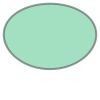

In [ ]:
wff.initial_cities_state.loc[
    wff.initial_cities_state["region_city"] == "Краснодарский край, Краснодар",
    "geometry",
].to_frame().to_crs(METRIC_CRS).buffer(DISTANCE_TRASHOLD_METERS).to_crs(
    DEGREE_CRS
).item()


In [ ]:
wff.cities.to_crs(DEGREE_CRS).explore()


In [ ]:
# make_folium_map(
#     wff.gdf_links[wff.gdf_links["destination"].isin(diff_l[mask]["destination"])],
#     wff.cities.to_crs(DEGREE_CRS).overlay(area),
# )


In [ ]:
name = "Ростовская область, Шахты"

original_flows_mask = wff.gdf_links["destination"].isin([name])

original_flows = wff.gdf_links[original_flows_mask]

original_cities = wff.cities.to_crs(DEGREE_CRS).loc[
    wff.cities["region_city"].isin(original_flows["origin"].values.tolist() + [name])
]


In [ ]:
# original_cities["flows_in"] /= 1e1

make_folium_map(
    original_flows,
    original_cities,
)


In [ ]:
"""PARAMS CHANGE EXAMPLE
"""

new_params = {
    # "population":222489,
    # "factories_total":15,
    "median_salary": 50_000,
    "ueqi_residential": 70,
    "ueqi_street_networks": 72,
    "ueqi_green_spaces": 71,
    "ueqi_public_and_business_infrastructure": 71,
    "ueqi_social_and_leisure_infrastructure": 74,
    "ueqi_citywide_space": 79,
    # "harsh_climate":0,
}

# Update the city data in the DataFrame
wff.update_city_params(name, new_params)
wff.recalculate_after_update()
diff = wff.compare_city_states()
diff_l = wff.compare_link_states()


Updated parameters for Ростовская область, Шахты
Recalculating after updating parameters


100%|██████████| 1106/1106 [00:00<00:00, 2261.78it/s]


Recalculation complete.


In [ ]:
original_flows_mask = wff.gdf_links["destination"].isin([name])

original_flows = wff.gdf_links[original_flows_mask]

original_cities = wff.cities.to_crs(DEGREE_CRS).loc[
    wff.cities["region_city"].isin(original_flows["origin"].values.tolist() + [name])
]

# original_cities["flows_in"] /= 1e2

make_folium_map(
    original_flows,
    original_cities,
)


In [ ]:
diff[diff["region_city"].isin(original_cities["region_city"])].sort_values(
    by="in_out_diff"
).dropna()


,region_city,geometry,in_out_diff,in_diff,out_diff
985,"Воронежская область, Эртиль",POINT (40.79925 51.83573),-10262.0,27011.0,37273.0
466,"Волгоградская область, Ленинск",POINT (45.19927 48.69361),-9583.0,10804.0,20387.0
48,"Астраханская область, Ахтубинск",POINT (46.17000 48.29000),-9460.0,9177.0,18637.0
614,"Ростовская область, Новошахтинск",POINT (39.93000 47.77000),-8653.0,11850.0,20503.0
428,"Саратовская область, Красный Кут",POINT (46.97120 50.95983),-7963.0,10685.0,18648.0
...,...,...,...,...,...
1076,"Калмыкия, Городовиковск",POINT (41.93605 46.08310),2567.0,18999.0,16432.0
309,"Ставропольский край, Ипатово",POINT (42.91116 45.71742),2570.0,17245.0,14675.0
702,"Ростовская область, Пролетарск",POINT (41.73000 46.70000),2679.0,20050.0,17371.0
741,"Ростовская область, Сальск",POINT (41.54000 46.47000),2684.0,19583.0,16899.0


In [ ]:
mask = (diff["in_out_diff"] != -10) & (
    diff["region_city"].isin(original_cities["region_city"])
)

diff[mask].dropna().explore(
    column="in_out_diff",
    tiles="Cartodb dark_matter",
    scheme="fisherjenks",
    cmap="Accent_r",
    style_kwds={"radius": 5},
)


In [ ]:
gg = pd.read_pickle(
    "/Users/test/Documents/code/IL2/factory_loc_service/api/app/data/grouped_grads.pkl"
).reset_index(drop=False)


In [ ]:
"Камчатский край, Елизово" in list(gg["cluster_center"].unique())


True

In [ ]:
# wff.cities.to_crs(DEGREE_CRS).overlay(area)


In [ ]:
# wff.gdf_links.clip(area).explore()


In [ ]:
# m.save("workflows.html")
